In [ ]:
from gGA.data import AtomicData, _keys
from ase.io import read
from gGA.data import OrbitalMapper
import torch
from gGA.data import block_to_feature
from gGA.utils.make_kpoints import kmesh_sampling

data = AtomicData.from_ase(read("/root/Hubbard/gGA/test/C_cube.vasp"), r_max=3.1)
basis = {"C":[2]}
idp_phy = OrbitalMapper(basis=basis, spin_deg=True)

In [ ]:
# hopping = torch.tensor([[1,0.2],[0.2,1]])
block = {
    "0_0_0_0_0": torch.zeros(2,2),
    "0_0_0_0_1": -torch.eye(2)*(1/6),
    "0_0_0_1_0": -torch.eye(2)*(1/6),
    "0_0_1_0_0": -torch.eye(2)*(1/6)
}

# block = {
#     "0_0_0_0_0": torch.zeros(2,2),
#     "0_0_0_0_1": -hopping*(1/6),
#     "0_0_0_1_0": -hopping*(1/6),
#     "0_0_1_0_0": -hopping*(1/6)
# }


block_to_feature(data, idp_phy, block)

kpoints = torch.tensor(kmesh_sampling([5,5,5], False)).float()
data[_keys.KPOINT_KEY] = kpoints

In [ ]:
from gGA.nn.gostG import GostGutzwiller

U = 3.0
J = 0. * U
Up = U - 2*J
Jp = J

model = GostGutzwiller(
    atomic_number=data[_keys.ATOMIC_NUMBERS_KEY], 
    nocc=2, 
    basis=basis, 
    naux=1,
    Hint_params={
        0: [{"U": U, "Up": Up, "J": J, "Jp": Jp, "l": torch.tensor([[0.2, 0], [0, -0.2]])}]
    },
    nk=125,
    spin_deg=True,
    device="cuda",
    kBT=0.0257, # corresponding to 298K - kBT = 0.0257 eV
)
# torch.tensor([[0.2, 0], [0, -0.2]])

In [ ]:
data = idp_phy(data.to(model.device))
data = AtomicData.to_AtomicDataDict(data)

In [ ]:
from gGA.nn.loss import GhostLoss, GhostLA, GhostCriteria
from gGA.nn.optimizer import AugmentedLagrange

gloss = GhostLoss()
gla = GhostLA()
gc = GhostCriteria()

AugLA = AugmentedLagrange(
    model, 
    lr=1e-1, 
    lossfn=gloss, 
    lagrangefn=gla, 
    criterion=gc, 
    delta=5e-3,
    delta_la=4e-3,
    sch_gamma=1.,
    sch_size=100,
    patience=30,
)

In [ ]:
# grad = [[],[]]
# phi = []
# density = []
coeff = []
for itr in range(15000):

    data, loss, crit = AugLA.step(data)
    coeff.append(model.interaction[0].singleOrbs[0].SBamp.detach().clone())
    # density.append(data["variational_density"].detach().cpu()-data["reduced_density_matrix"].detach().cpu())
    # phi.append(model.interaction[0].singleOrbs[0].SBamp.clone())
    # param = list(model.parameters())
    # grad[0].append(param[0].grad.clone())
    # grad[1].append(param[1].grad.clone())
    # AugLA.optimizer.zero_grad()
    RTR = torch.bmm(data[_keys.R_MATRIX_KEY].transpose(1,2), data[_keys.R_MATRIX_KEY])
    
    if itr % 5 == 0:
        print("iter {}\t loss: {:.4f}, CC: {:.6f}, T+U: {:.4f}, T: {:.4f}, U: {:.4f}, NI: {:.3f}, devD: {:.4f}, devR: {:.4f}, lr: {:.4f}, muD: {:.1f}".format(
            itr, 
            loss.detach().item(),
            crit,
            data[_keys.TOTAL_ENERGY_KEY].detach().item()+data[_keys.INTERACTION_ENERGY_KEY].detach().item(),
            data[_keys.TOTAL_ENERGY_KEY].detach().item(), 
            data[_keys.INTERACTION_ENERGY_KEY].detach().item(),
            data[_keys.VARIATIONAL_DENSITY_KEY].detach().diag().sum(),
            (data[_keys.VARIATIONAL_DENSITY_KEY].detach()-data[_keys.REDUCED_DENSITY_MATRIX_KEY].detach()).abs().max(),
            (RTR - gla.bdiag(gla.bdiag(RTR))).abs().max(),
            AugLA.optimizer.param_groups[0]["lr"],
            AugLA.muD,
            # AugLA.muR
            )
        )
        # print((model.interaction[0].singleOrbs[0].check_B()).norm().detach().item())

# torch.save(grad, "grad.pt")


In [ ]:
model.lagrangian[0], model.augfactor[0]

In [ ]:
AugLA.optimizer_la.zero_grad()
AugLA.optimizer.zero_grad()

In [ ]:
data = model(data) # it is not T or U 's backward make gradient of SBamp explode or non-vanishing

In [ ]:
err = (torch.block_diag(*model.lagrangian) * (data[_keys.REDUCED_DENSITY_MATRIX_KEY] - data[_keys.VARIATIONAL_DENSITY_KEY])**2).abs().sum()

In [ ]:
err.backward()

In [ ]:
for p in model.parameters():
    print(p.grad)

In [ ]:
coeff = torch.stack(coeff)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,3))
plt.plot(coeff.cpu().numpy())
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(model.interaction[0].singleOrbs[0].Hint.to_dense().cpu(), cmap="bwr", vmin=-1, vmax=1)

In [ ]:
torch.linalg.eigh(model.interaction[0].singleOrbs[0].Hint.to_dense())

In [ ]:
SBamp = model.interaction[0].singleOrbs[0].SBamp

vnorm = SBamp.norm()
sb = torch.cat([2*SBamp, vnorm.unsqueeze(0)**2-1]) / (vnorm**2+1)
sb = torch.sparse_coo_tensor(model.interaction[0].singleOrbs[0].indices, sb, model.interaction[0].singleOrbs[0].size).coalesce()

In [ ]:
data["variational_density"]

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(sb.to_dense().detach().cpu())
plt.plot()
plt.matshow((sb.to_dense() @ sb.to_dense().T).detach().cpu())
plt.plot()
plt.matshow((sb.to_dense().T @ sb.to_dense()).detach().cpu())
plt.plot()

In [ ]:
from gGA.model.operators import annis
plt.matshow((annis[(2, 1, 0)].to_dense().T @ annis[(2, 1, 0)].to_dense()).cpu())
plt.show()


In [ ]:
import matplotlib.pyplot as plt
phi = torch.stack(phi)

In [ ]:
plt.plot((phi / phi.norm(dim=0, keepdim=True)).detach().cpu().numpy())
plt.show()

In [ ]:
model.lagrangian[0], data["variational_density"], data["reduced_density_matrix"]

In [ ]:
model.interaction[0].compute_density().reshape(4,4)

In [ ]:
data["r_matrix"][0].T @ data["r_matrix"][0]

In [ ]:
model.interaction[0].singleOrbs[0].check_B()

In [ ]:
data[_keys.VARIATIONAL_DENSITY_KEY], data[_keys.REDUCED_DENSITY_MATRIX_KEY]

In [ ]:
import matplotlib.pyplot as plt
# phi = torch.stack(phi)
phi = phi /  phi.norm(dim=-1, keepdim=True)
plt.figure(figsize=(10,3))
plt.plot(phi[:,:].cpu().detach().numpy())
# plt.plot(grad[1].cpu().abs().reshape(448,-1).max(dim=1)[0])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(model.interaction[0].singleOrbs[0].check_sbbs().to_dense().detach().cpu(), cmap="bwr", vmax=0.1, vmin=-0.1)
plt.show()

plt.matshow(model.interaction[0].singleOrbs[0].Hint.to_dense().detach().cpu(), cmap="bwr", vmax=0.1, vmin=-0.1)
plt.show()

In [ ]:
model.interaction[0].singleOrbs[0].compute_density().reshape(4,4)

In [ ]:
mask = (model.interaction[0].singleOrbs[0].SBamp / model.interaction[0].singleOrbs[0].SBamp.norm()).abs().gt(0.08)

In [ ]:
(model.interaction[0].singleOrbs[0].SBamp / model.interaction[0].singleOrbs[0].SBamp.norm())[mask]

In [ ]:
torch.tensor(model.interaction[0].singleOrbs[0].basis)[mask.cpu()]

In [ ]:
vec = torch.zeros(16)
vec[5] = 1
vec.T @ model.interaction[0].singleOrbs[0].Hint.to_dense().cpu() @ vec

In [ ]:
mask = (model.interaction[0].singleOrbs[0].SBamp.abs() / model.interaction[0].singleOrbs[0].SBamp.norm()).gt(0.05)

In [ ]:
torch.cat([model.interaction[0].singleOrbs[0].basis, model.interaction[0].singleOrbs[0].SBamp.unsqueeze(1)], dim=-1)[mask]

In [ ]:
import torch

M = torch.randn(10,10)
M = M + M.T
M[:5,:5] = 0

In [ ]:
A = M[:3,3:].clone()
B = M[3:,3:].clone()
Binv = B.inverse()
ABinv = torch.linalg.solve(B.T, A.T).T
inv00 = -(ABinv @ A.T).inverse()
inv01 = -inv00 @ ABinv
inv11 = Binv - ABinv.T @ inv01



In [ ]:
import matplotlib.pyplot as plt
plt.matshow(M.inverse() - Minv, cmap="bwr", vmax=0.1, vmin=-0.1)
plt.show()

In [40]:
import torch

a = torch.randn(12,12)
a = a + a.T

In [41]:
val, vec = torch.linalg.eigh(a)
vec = vec.T[7:]

In [42]:
dm = vec.T @ vec

In [43]:
bath = dm[4:,4:] # 4 spin orbital (interaction), 8 bath spin orbital

In [44]:
bval, bvec = torch.linalg.eigh(bath)
bvec = bvec.T[[3,4,5,6,0,1,2,7]]
bval = bval[[3,4,5,6,0,1,2,7]]

In [45]:
bval

tensor([ 4.4934e-01,  5.0382e-01,  6.5473e-01,  8.4197e-01, -1.0670e-07,
        -2.6161e-08,  6.1539e-08,  1.0000e+00])

In [46]:
b = dm.clone()
b[4:,4:] = bvec @ b[4:,4:] @ bvec.T
b[4:,:4] = bvec @ b[4:,:4]
b[:4, 4:] = b[:4, 4:] @ bvec.T

hb = a.clone()
hb[4:,4:] = bvec @ hb[4:,4:] @ bvec.T
hb[4:,:4] = bvec @ hb[4:,:4]
hb[:4, 4:] = hb[:4, 4:] @ bvec.T

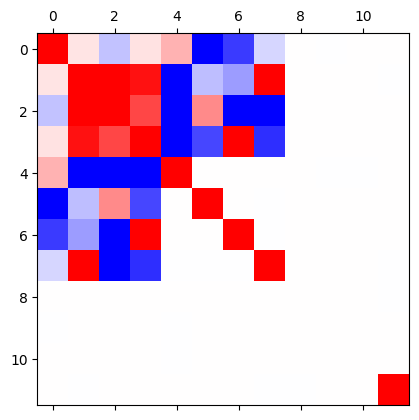

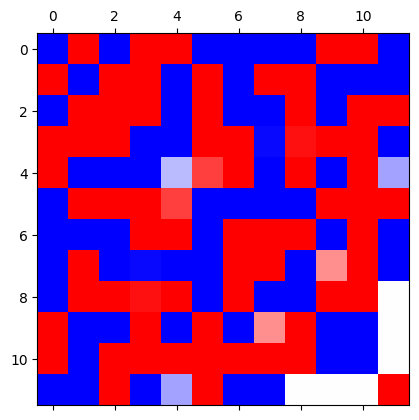

In [47]:
import matplotlib.pyplot as plt
plt.matshow(b, cmap="bwr", vmax=0.1, vmin=-0.1)
plt.show()

plt.matshow(hb, cmap="bwr", vmax=0.1, vmin=-0.1)
plt.show()

In [48]:
ibval, ibvec = torch.linalg.eigh(b[:8,:8])
ibvec = ibvec.T

In [49]:
dcb = hb.clone()
dcb[:8,:8] = ibvec @ dcb[:8,:8] @ ibvec.T
dcb[:8,8:] = ibvec @ dcb[:8,8:]
dcb[8:,:8] = dcb[8:,:8] @ ibvec.T

dcdm = b.clone()
dcdm[:8,:8] = ibvec @ dcdm[:8,:8] @ ibvec.T
dcdm[:8,8:] = ibvec @ dcdm[:8,8:]
dcdm[8:,:8] = dcdm[8:,:8] @ ibvec.T

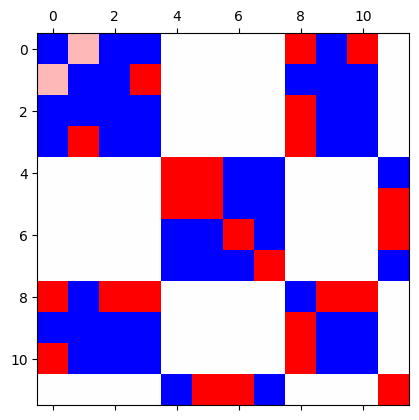

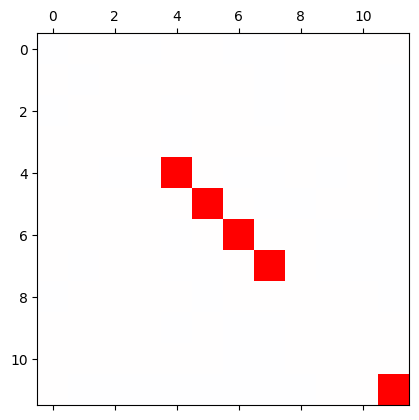

In [50]:
plt.matshow(dcb, cmap="bwr", vmax=0.1, vmin=-0.1)
plt.show()
plt.matshow(dcdm, cmap="bwr", vmax=0.1, vmin=-0.1)
plt.show()

In [51]:
cdcb = dcb.clone()

_, bath_transform = torch.linalg.eigh(cdcb[8:11, 8:11])
bath_transform = bath_transform.T

In [52]:
cdcb[8:11, :] = bath_transform @ cdcb[8:11, :]
cdcb[:, 8:11] = cdcb[:, 8:11] @ bath_transform.T

conduction = torch.zeros(7,7)
conduction[:4,:4] = cdcb[:4,:4]
conduction[:4,4:] = cdcb[:4,8:11]
conduction[4:,:4] = cdcb[8:11,:4]
conduction[4:,4:] = cdcb[8:11,8:11]

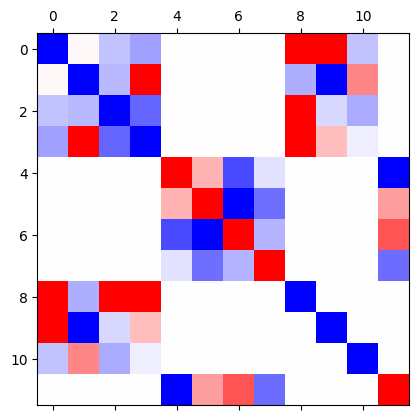

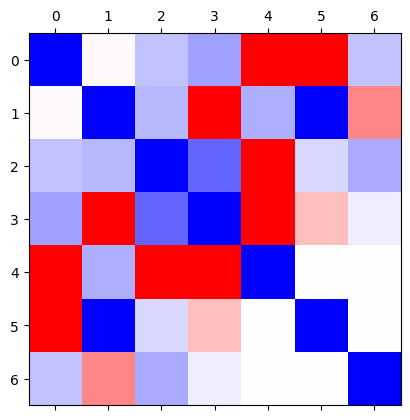

In [53]:
plt.matshow(cdcb, cmap="bwr", vmax=1, vmin=-1)
plt.show()
plt.matshow(conduction, cmap="bwr", vmax=1, vmin=-1)
plt.show()

In [57]:
a = torch.randn(4,4)
_, vec = torch.linalg.eigh(a @ a.T)
vec = vec.T
print(vec @ a @ a.T @ vec.T)
print(vec @ a)

tensor([[ 1.5017e-01,  2.0544e-07, -2.1078e-09, -3.6832e-07],
        [ 2.2027e-07,  8.4198e-01, -1.0613e-07,  2.3572e-07],
        [ 4.4580e-08, -9.4624e-08,  3.3759e+00, -3.9509e-07],
        [-3.3275e-07,  2.5382e-07, -4.4615e-07,  8.8702e+00]])
tensor([[-0.0759,  0.1972, -0.3207,  0.0518],
        [-0.0432, -0.4610, -0.1475,  0.7783],
        [ 1.7987,  0.0994, -0.3495,  0.0926],
        [-0.0983, -2.0756, -1.4986, -1.5188]])


In [278]:
import scipy as sp
import numpy as np

N = 8
a = np.random.randn(N,N)
a = a + a.T
a = a + 30 * np.eye(N)
a[0][0] = 28

# a = np.random.randn(100,100)
# a = a+ a.T

In [279]:
eigmin = np.linalg.eigvalsh(a).min()

In [284]:
q = np.zeros(N)
q[0] = 1
# q = np.random.randn(a.shape[0])
# q = q / np.linalg.norm(q)
es = []
for i in range(2,N+1):
    Q = lanczos(a,2,i)
    es.append(np.linalg.eigvalsh(Q.T @ a @ Q).min()-eigmin)

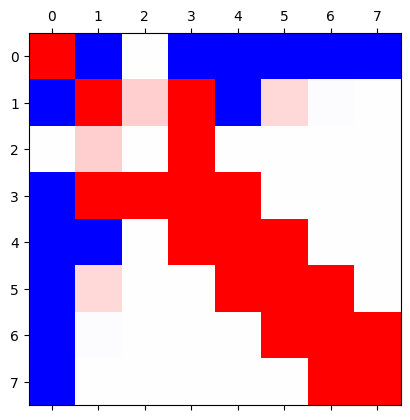

In [285]:
import matplotlib.pyplot as plt
plt.matshow(Q.T @ a @ Q, cmap="bwr", vmax=0.1, vmin=-0.1)
plt.show()

In [251]:
Q

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.60339793,  0.577973  ,  0.5494162 ],
       [ 0.        ,  0.        ,  0.41403625, -0.36176473,  0.83528454],
       [ 0.        ,  0.        , -0.68153131, -0.73148718,  0.02101369]])

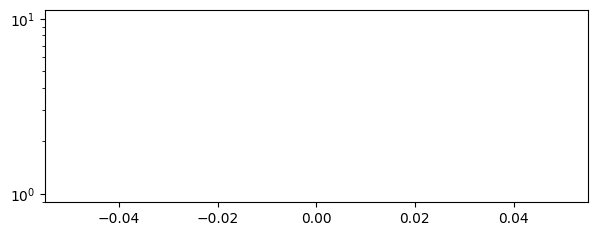

In [215]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,2.5))
plt.plot(es)
plt.yscale("log")
plt.show()

In [ ]:
from numpy import sqrt, newaxis, dot, conj, array, zeros, ndim, append
import numpy as np
import scipy.sparse as sps
import warnings

def lanczos(A, s=None, m=None):
    """
    Use m steps of the lanczos algorithm starting with q to generate
    the tridiagonal form of this matrix(The traditional scalar version).

    Parameters:
        :A: A sparse hermitian matrix.
        :s: The starting site, the 1-s site will be treated as a block.
        :m: The steps to run.
        :getbasis: Return basis vectors if True.

    Return:
        Tridiagonal part elements (data,offset),
        | data -> (lower part, middle part, upper part)
        | offset -> (-1, 0, 1) to indicate the value of (j-i) of specific data with i,j the matrix element indices.

    To construct the matrix, set the block-matrix elements with block indices j-i == offset[k] to data[k].
    This is exactly what `construct_tridmat` function do.

    **Note:** The initial vector q will be renormalized to guarant the correctness of result,
    """
    if sps.issparse(A): A=A.toarray()
    if m==None:
        m=A.shape[0]

    if s is None:
        s = 1

    #initialize states
    Q = np.zeros((A.shape[0],s))
    Q[:s,:s] = np.eye(s)
    
    #run steps
    for i in range(s-1,m):
        Q_=Q[:,i]
        z = A.dot(Q_)
        tmp = dot(conj(Q.T), z)
        tmp = dot(Q, tmp)
        z = z - tmp
        beta_i = sqrt(dot(conj(z),z))
        if i==m-1: break
        z=z/beta_i
        Q_i=icgs(z[:,newaxis],Q)
        Q=append(Q,Q_i,axis=-1)

    return Q

def icgs(u,Q,M=None,return_norm=False,maxiter=3):
    '''
    Iterative Classical M-orthogonal Gram-Schmidt orthogonalization.

    Parameters:
        :u: vector, the column vector to be orthogonalized.
        :Q: matrix, the search space.
        :M: matrix/None, the matrix, if provided, perform M-orthogonal.
        :return_norm: bool, return the norm of u.
        :maxiter: int, the maximum number of iteractions.

    Return:
        vector, orthogonalized vector u.
    '''
    assert(ndim(u)==2)
    uH,QH=u.T.conj(),Q.T.conj()
    alpha=0.5
    it=1
    Mu=M.dot(u) if M is not None else u
    r_pre=np.linalg.norm(uH.dot(Mu))
    for it in range(maxiter):
        u=u-Q.dot(QH.dot(Mu))
        Mu=M.dot(u) if M is not None else u
        r1=np.linalg.norm(uH.dot(Mu))
        if r1>alpha*r_pre:
            break
        r_pre=r1
    if r1<=alpha*r_pre:
        warnings.warn('loss of orthogonality @icgs.')
    return (u,r1) if return_norm else u

Original matrix:
[[ 0.49671415  0.05184899  0.05165291  0.86594673  0.05473246 -0.3566556
   0.77169339 -0.02052944 -0.08667705  0.40005522  0.16380713 -0.76401673]
 [ 0.05184899 -1.91328024 -0.80699762 -1.26097883 -1.38793564  0.06429418
   0.32830979 -0.95703037  0.86335202 -0.15011111 -0.42092963 -0.47557788]
 [ 0.05165291 -0.80699762 -1.15099358 -0.47624402 -0.13827736 -0.69901436
  -1.61072586  1.38384015 -0.00419188 -1.48824107  1.11266961 -1.07013394]
 [ 0.86594673 -1.26097883 -0.47624402  0.19686124  0.17669215 -0.51241917
   0.35312711  0.01382371 -0.85655456 -0.37317904 -0.93124492  1.30352832]
 [ 0.05473246 -1.38793564 -0.13827736  0.17669215 -0.676922    0.71210106
   0.5590233   0.20075996 -1.12729413 -0.12449108  0.45906026  0.09614592]
 [-0.3566556   0.06429418 -0.69901436 -0.51241917  0.71210106  1.35624003
  -0.18550874  0.75840017 -0.02950465  0.90906118  1.27592562  0.60798753]
 [ 0.77169339  0.32830979 -1.61072586  0.35312711  0.5590233  -0.18550874
   0.09176078 -0

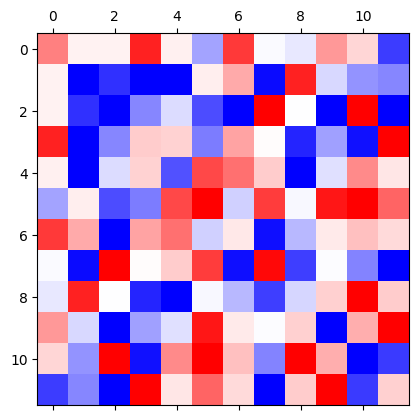

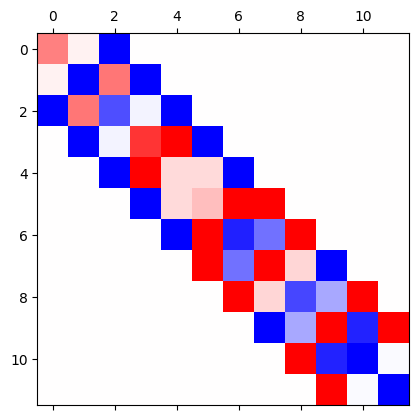

In [318]:
import numpy as np
from scipy import linalg

def block_lanczos(A, block_size, max_iterations=None):
    """
    Perform block Lanczos tridiagonalization while preserving the first block.
    
    Args:
        A (numpy.ndarray): Input symmetric matrix of size n×n
        block_size (int): Size of blocks (m×m)
        max_iterations (int): Maximum number of iterations (default: None)
        
    Returns:
        T (numpy.ndarray): Block tridiagonal matrix
        V (numpy.ndarray): Matrix of Lanczos vectors
    """
    n = A.shape[0]
    if n % block_size != 0:
        raise ValueError("Matrix size must be divisible by block_size")
    
    num_blocks = n // block_size
    if max_iterations is None:
        max_iterations = num_blocks
    
    # Initialize arrays to store results
    T = np.zeros_like(A)
    V = np.zeros((n, n))  # Store Lanczos vectors
    
    # Initialize first block vector (normalized)
    V_prev = np.zeros((n, block_size))
    V_curr = np.eye(n, block_size)  # Start with identity block
    q, r = np.linalg.qr(V_curr)  # QR decomposition for orthonormalization
    V_curr = q
    
    # Store first Lanczos vectors
    V[:, :block_size] = V_curr
    
    # First block multiplication
    W = A @ V_curr
    
    # First diagonal block
    alpha = V_curr.T @ W
    T[:block_size, :block_size] = alpha
    W = W - V_curr @ alpha
    
    for j in range(1, max_iterations):
        start_j = j * block_size
        end_j = start_j + block_size
        
        # Skip if we've reached the end
        if end_j > n:
            break
            
        # Compute beta (off-diagonal block)
        q, beta = np.linalg.qr(W)
        V_next = q
        
        # Reorthogonalization against previous vectors
        for k in range(j):
            start_k = k * block_size
            end_k = start_k + block_size
            proj = V[:, start_k:end_k].T @ V_next
            V_next = V_next - V[:, start_k:end_k] @ proj
        
        # Reorthogonalize again and normalize
        q, r = np.linalg.qr(V_next)
        V_next = q
        
        # Store the Lanczos vectors
        V[:, start_j:end_j] = V_next
        
        # Store beta blocks
        T[start_j:end_j, start_j-block_size:start_j] = beta
        T[start_j-block_size:start_j, start_j:end_j] = beta.T
        
        # Compute new W
        W = A @ V_next - V_curr @ beta.T
        
        # Compute and store alpha
        alpha = V_next.T @ W
        T[start_j:end_j, start_j:end_j] = alpha
        
        # Update W
        W = W - V_next @ alpha
        
        # Update V vectors for next iteration
        V_prev = V_curr
        V_curr = V_next
        
    return T, V

def verify_tridiagonal_structure(matrix, block_size):
    """
    Verify the block tridiagonal structure of the matrix.
    """
    n = matrix.shape[0]
    num_blocks = n // block_size
    
    for i in range(num_blocks):
        for j in range(num_blocks):
            if abs(i-j) > 1:
                start_i = i * block_size
                end_i = start_i + block_size
                start_j = j * block_size
                end_j = start_j + block_size
                block = matrix[start_i:end_i, start_j:end_j]
                if not np.allclose(block, 0, atol=1e-10):
                    return False
    return True

# Example usage and testing
def run_example():
    # Create a test matrix
    n = 12  # Matrix size
    m = 2  # Block size
    np.random.seed(42)
    
    # Create a symmetric matrix
    A = np.random.randn(n, n)
    A = (A + A.T) / 2
    
    # Perform block Lanczos
    T, V = block_lanczos(A, m)
    
    print("Original matrix:")
    print(A)
    print("\nBlock tridiagonal matrix:")
    print(T)
    
    # Verify properties
    print("\nVerification:")
    print("First block preserved:", np.allclose(A[:m, :m], T[:m, :m]))
    print("Matrix is symmetric:", np.allclose(T, T.T))
    print("Block tridiagonal structure maintained:", 
          verify_tridiagonal_structure(T, m))
    
    # Verify the transformation
    print("Orthogonal transformation preserved properties:", 
          np.allclose(V.T @ A @ V, T))
    
    return A, T, V

A, T, V = run_example()
import matplotlib.pyplot as plt

plt.matshow(A, cmap="bwr", vmax=1, vmin=-1)
plt.show()

plt.matshow(T, cmap="bwr", vmax=1, vmin=-1)
plt.show()

In [314]:
import numpy as np
from scipy import linalg

def householder_vector(x):
    """
    Compute Householder vector to zero out elements.
    """
    n = len(x)
    v = x.copy()
    norm_x = np.linalg.norm(x)
    
    if norm_x < 1e-15:
        return np.zeros_like(x)
    
    if x[0] >= 0:
        v[0] += norm_x
    else:
        v[0] -= norm_x
        
    v = v / np.linalg.norm(v)
    return v

def apply_householder(A, v, side='both'):
    """
    Apply Householder transformation to matrix A.
    """
    H = np.eye(A.shape[0]) - 2 * np.outer(v, v)
    if side == 'both':
        return H @ A @ H
    elif side == 'left':
        return H @ A
    else:  # right
        return A @ H

def hybrid_tridiagonalization(A, block_size):
    """
    Hybrid tridiagonalization preserving first block_size × block_size block
    using Householder for block part and Lanczos for scalar part.
    """
    n = A.shape[0]
    if not np.allclose(A, A.T):
        raise ValueError("Matrix must be symmetric")
    
    # Make working copy
    T = A.copy()
    V = np.eye(n)
    
    # Step 1: Preserve the first block
    block = T[:block_size, :block_size].copy()
    
    # Step 2: Use Householder to handle transition region
    for i in range(block_size, n-1):
        # Get the column we want to zero out
        x = T[i+1:, i].copy()
        
        if np.linalg.norm(x) > 1e-15:
            # Compute Householder vector
            v = np.zeros(n)
            v[i+1:] = householder_vector(x)
            
            # Apply transformation
            T = apply_householder(T, v, 'both')
            V = V @ (np.eye(n) - 2 * np.outer(v, v))
    
    # Step 3: Restore the first block
    T[:block_size, :block_size] = block
    
    # Step 4: Clean up numerical errors
    # Make sure the matrix is symmetric
    T = (T + T.T) / 2
    
    # Zero out elements that should be zero
    for i in range(n):
        for j in range(n):
            if i < block_size and j >= block_size and j > block_size:
                T[i,j] = T[j,i] = 0
            if i >= block_size and j >= block_size and abs(i-j) > 1:
                T[i,j] = T[j,i] = 0
            
    return T, V

def verify_results(A, T, V, block_size, tol=1e-10):
    """
    Comprehensive verification of the transformation results.
    """
    n = A.shape[0]
    results = {}
    
    # Check if V is orthogonal
    VTV = V.T @ V
    results['orthogonality_error'] = np.max(np.abs(VTV - np.eye(n)))
    
    # Check if transformation works
    VTAV = V.T @ A @ V
    results['transformation_error'] = np.max(np.abs(VTAV - T))
    
    # Check if first block is preserved
    results['block_preservation_error'] = np.max(np.abs(A[:block_size, :block_size] - T[:block_size, :block_size]))
    
    # Check tridiagonal structure after block
    structure_valid = True
    for i in range(block_size, n):
        for j in range(block_size, n):
            if abs(i-j) > 1 and abs(T[i,j]) > tol:
                structure_valid = False
                break
    results['structure_valid'] = structure_valid
    
    return results

def run_test():
    # Create test matrix
    n = 8
    block_size = 3
    np.random.seed(42)
    
    # Create symmetric matrix
    A = np.random.rand(n, n)
    A = (A + A.T) / 2
    
    # Perform transformation
    T, V = hybrid_tridiagonalization(A, block_size)
    
    # Verify results
    results = verify_results(A, T, V, block_size)
    
    print("\nVerification Results:")
    print(f"Orthogonality Error: {results['orthogonality_error']:.2e}")
    print(f"Transformation Error: {results['transformation_error']:.2e}")
    print(f"Block Preservation Error: {results['block_preservation_error']:.2e}")
    print(f"Structure Valid: {results['structure_valid']}")
    
    print("\nOriginal matrix:")
    print(A)
    print("\nTransformed matrix:")
    print(T)
    print("\nNon-zero pattern:")
    print(np.where(np.abs(T) > 1e-10, 1, 0))
    
    return A, T, V, results

# Run test
A, T, V, results = run_test()


Verification Results:
Orthogonality Error: 4.44e-16
Transformation Error: 9.64e-01
Block Preservation Error: 0.00e+00
Structure Valid: True

Original matrix:
[[0.37454012 0.77591466 0.51811809 0.52736423 0.11053512 0.13901638
  0.30239695 0.47733432]
 [0.77591466 0.70807258 0.27267046 0.87754291 0.89066409 0.35375801
  0.18333971 0.18969369]
 [0.51811809 0.27267046 0.43194502 0.24545146 0.78874246 0.08694119
  0.63086464 0.20579457]
 [0.52736423 0.87754291 0.24545146 0.51423444 0.70040596 0.47788541
  0.69133884 0.24792723]
 [0.11053512 0.89066409 0.78874246 0.70040596 0.30461377 0.17822605
  0.81186598 0.41441489]
 [0.13901638 0.35375801 0.08694119 0.47788541 0.17822605 0.66252228
  0.60326921 0.39570853]
 [0.30239695 0.18333971 0.63086464 0.69133884 0.81186598 0.60326921
  0.59789998 0.87530587]
 [0.47733432 0.18969369 0.20579457 0.24792723 0.41441489 0.39570853
  0.87530587 0.35675333]]

Transformed matrix:
[[ 0.37454012  0.77591466  0.51811809  0.52736423  0.          0.
   0.    

In [20]:
import numpy as np
import scipy.linalg as la

def non_interacting_tridiagonalization(H_original):
    """
    Tridiagonalize a non-interacting Hamiltonian
    
    Parameters:
    -----------
    H_original : ndarray
        Original Hamiltonian matrix with non-interacting couplings
    
    Returns:
    --------
    H_tridi : ndarray
        Tridiagonalized Hamiltonian preserving original structure
    """
    # Symmetric tridiagonalization using Lanczos algorithm variant
    n = H_original.shape[0]
    H_tridi = np.zeros_like(H_original)
    
    # Preserve diagonal elements
    np.fill_diagonal(H_tridi, np.diag(H_original))
    
    # Construct tridiagonal structure
    for i in range(n-1):
        # Diagonal coupling to next site
        H_tridi[i, i+1] = H_original[i, i+1]
        H_tridi[i+1, i] = H_original[i+1, i]
    
    return H_tridi

# Example usage
def example():
    # Create a sample Hamiltonian with non-interacting couplings
    H = np.array([
        [1.0, 0.3, 0.1, 0.0],
        [0.3, 2.0, 0.2, 0.1],
        [0.1, 0.2, 3.0, 0.4],
        [0.0, 0.1, 0.4, 4.0]
    ])
    
    H_tridi = non_interacting_tridiagonalization(H)
    print("Original Hamiltonian:\n", H)
    print("\nTridiagonalized Hamiltonian:\n", H_tridi)

if __name__ == "__main__":
    example()

Original Hamiltonian:
 [[1.  0.3 0.1 0. ]
 [0.3 2.  0.2 0.1]
 [0.1 0.2 3.  0.4]
 [0.  0.1 0.4 4. ]]

Tridiagonalized Hamiltonian:
 [[1.  0.3 0.  0. ]
 [0.3 2.  0.2 0. ]
 [0.  0.2 3.  0.4]
 [0.  0.  0.4 4. ]]
